In [1]:
from astropy.modeling.astro_sherpa import SherpaFitter
from astropy.modeling.models import Gaussian2D
from sherpa.stats import Chi2
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Lets make some X,Y data

In [2]:
np.random.seed(123456789)
x0low, x0high = 3000, 4000
x1low, x1high = 4000, 4800
dx = 15
x1, x0 = np.mgrid[x1low:x1high:dx, x0low:x0high:dx]
shape = x0.shape
x0, x1 = x0.flatten(), x1.flatten()

We define some Z data and Noise 

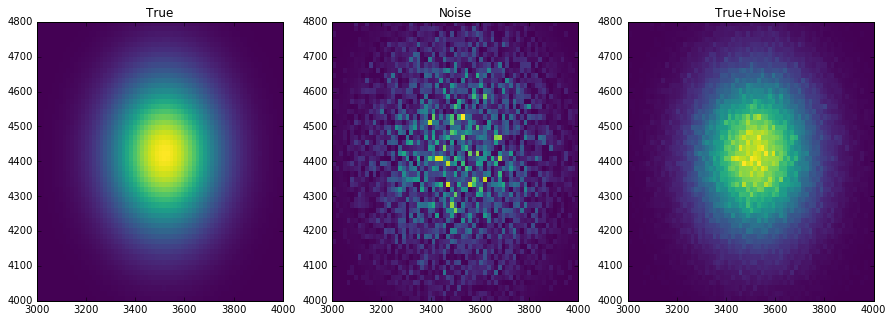

In [3]:
plt.rcParams['figure.figsize']=(15,5)

truth = Gaussian2D(x_mean=3512, y_mean=4418, x_stddev=150, y_stddev=150,
                   theta=20, amplitude=100)
mexp = truth(x0, x1).reshape(shape)
merr = abs(np.random.poisson(mexp) - mexp)

plt.subplot(1,3,1)
plt.imshow(mexp, origin='lower', cmap='viridis',
           extent=(x0low, x0high, x1low, x1high),
           interpolation='nearest', aspect='auto')
plt.title("True")
plt.subplot(1,3,2)
plt.imshow(merr, origin='lower', cmap='viridis',
           extent=(x0low, x0high, x1low, x1high),
           interpolation='nearest', aspect='auto')
plt.title("Noise")
plt.subplot(1,3,3)
plt.imshow((mexp + merr), origin='lower', cmap='viridis',
           extent=(x0low, x0high, x1low, x1high),
           interpolation='nearest', aspect='auto')
plt.title("True+Noise")

Lets fit the data after I offset the values, and lets look at the residuals!

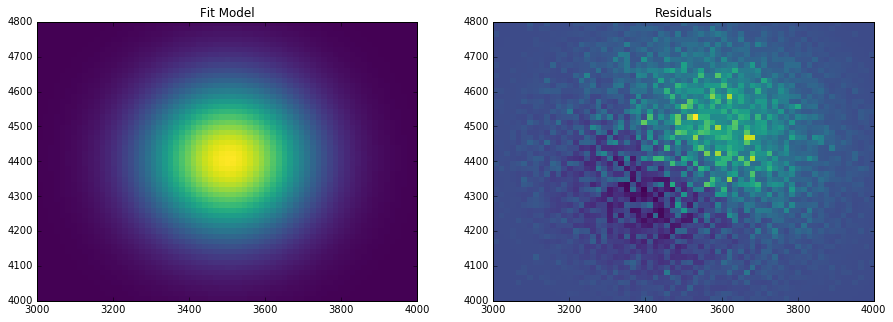

In [8]:
sfit = SherpaFitter(statistic=Chi2)
fitmo = truth.copy()
fitmo.x_mean = 3650
fitmo.y_mean = 4250
fitmo.x_stddev = 100
fitmo.y_stddev = 100
fitmo.theta = 10
fitmo.amplitude = 50

fitmo = sfit(fitmo, x0, x1, mexp.flatten()+merr.flatten(), xerr=np.ones(x0.shape)*dx, 
             yerr=np.ones(x1.shape)*dx, zerr=merr.flatten())

plt.subplot(1,2,1)
plt.imshow(fitmo(x0,x1).reshape(shape), origin='lower', cmap='viridis',
           extent=(x0low, x0high, x1low, x1high),
           interpolation='nearest', aspect='auto')
plt.title("Fit Model")

res = (mexp + merr) - fitmo(x0, x1).reshape(shape)
plt.subplot(1,2,2)
plt.imshow(res, origin='lower', cmap='viridis',
           extent=(x0low, x0high, x1low, x1high),
           interpolation='nearest', aspect='auto')
plt.title("Residuals")

Finally we should check out the errors

In [9]:
stat_res = sfit.est_errors()
for pres in zip([p.split(".")[-1] for p in stat_res.parnames], stat_res.parvals, 
                stat_res.parmins, stat_res.parmaxes):
    truval = getattr(truth, pres[0])
    if pres[-1] is not None and pres[-2] is not None:
        print "%s %.2e %.2e %.2e %.1f" %\
        tuple(list(pres) + [abs(pres[1] - truval) * 100.0 / truval]) + "%"
    else:
        print "%s %.2e Limit Reached Limit Reached %.1f" %\
        tuple(list(pres[:2]) + [abs(pres[1] - truval) * 100.0 / truval]) + "%"

amplitude 1.00e+02 -9.42e-02 9.42e-02 0.1%
x_mean 3.50e+03 -9.99e-02 9.99e-02 0.4%
y_mean 4.40e+03 -1.16e-01 1.16e-01 0.3%
x_stddev 1.51e+02 -8.78e-02 8.78e-02 0.5%
y_stddev 1.51e+02 -1.04e-01 1.04e-01 0.8%
theta 9.17e+00 -1.29e-01 1.29e-01 54.1%


In [6]:
sfit._fitter.est_errors

<bound method Fit.est_errors of <sherpa.fit.Fit object at 0x7f6cedba8210>>